In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') # '나눔고딕' 폰트 적용



In [52]:
x_train = pd.read_csv('물류train.csv')
x_test = pd.read_csv('물류test.csv')

x_train.shape, x_test.shape

((31684, 5), (7920, 4))

In [53]:
# train.head()

In [54]:
# # 송하인_격자공간고유번호 , 수하인_격자공간고유번호 문자열로 처리
# x_train['송하인_격자공간고유번호'] = x_train['송하인_격자공간고유번호'].astype('str')
# x_train['수하인_격자공간고유번호'] = x_train['수하인_격자공간고유번호'].astype('str')


# x_test['송하인_격자공간고유번호'] = x_test['송하인_격자공간고유번호'].astype('str')
# x_test['수하인_격자공간고유번호'] = x_test['수하인_격자공간고유번호'].astype('str')



In [55]:
x_train.head()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


In [56]:
x_train['물품_카테고리'].value_counts()

물품_카테고리
농산물              20321
문화컨텐츠             1091
음료                1034
수산                 860
가공식품               846
                 ...  
유아가구                 4
기타출산/육아              4
태블릿PC/노트북액세서리        4
선케어                  4
스포츠잡화                4
Name: count, Length: 100, dtype: int64

### 결측치 시각적으로 확인

<Axes: >

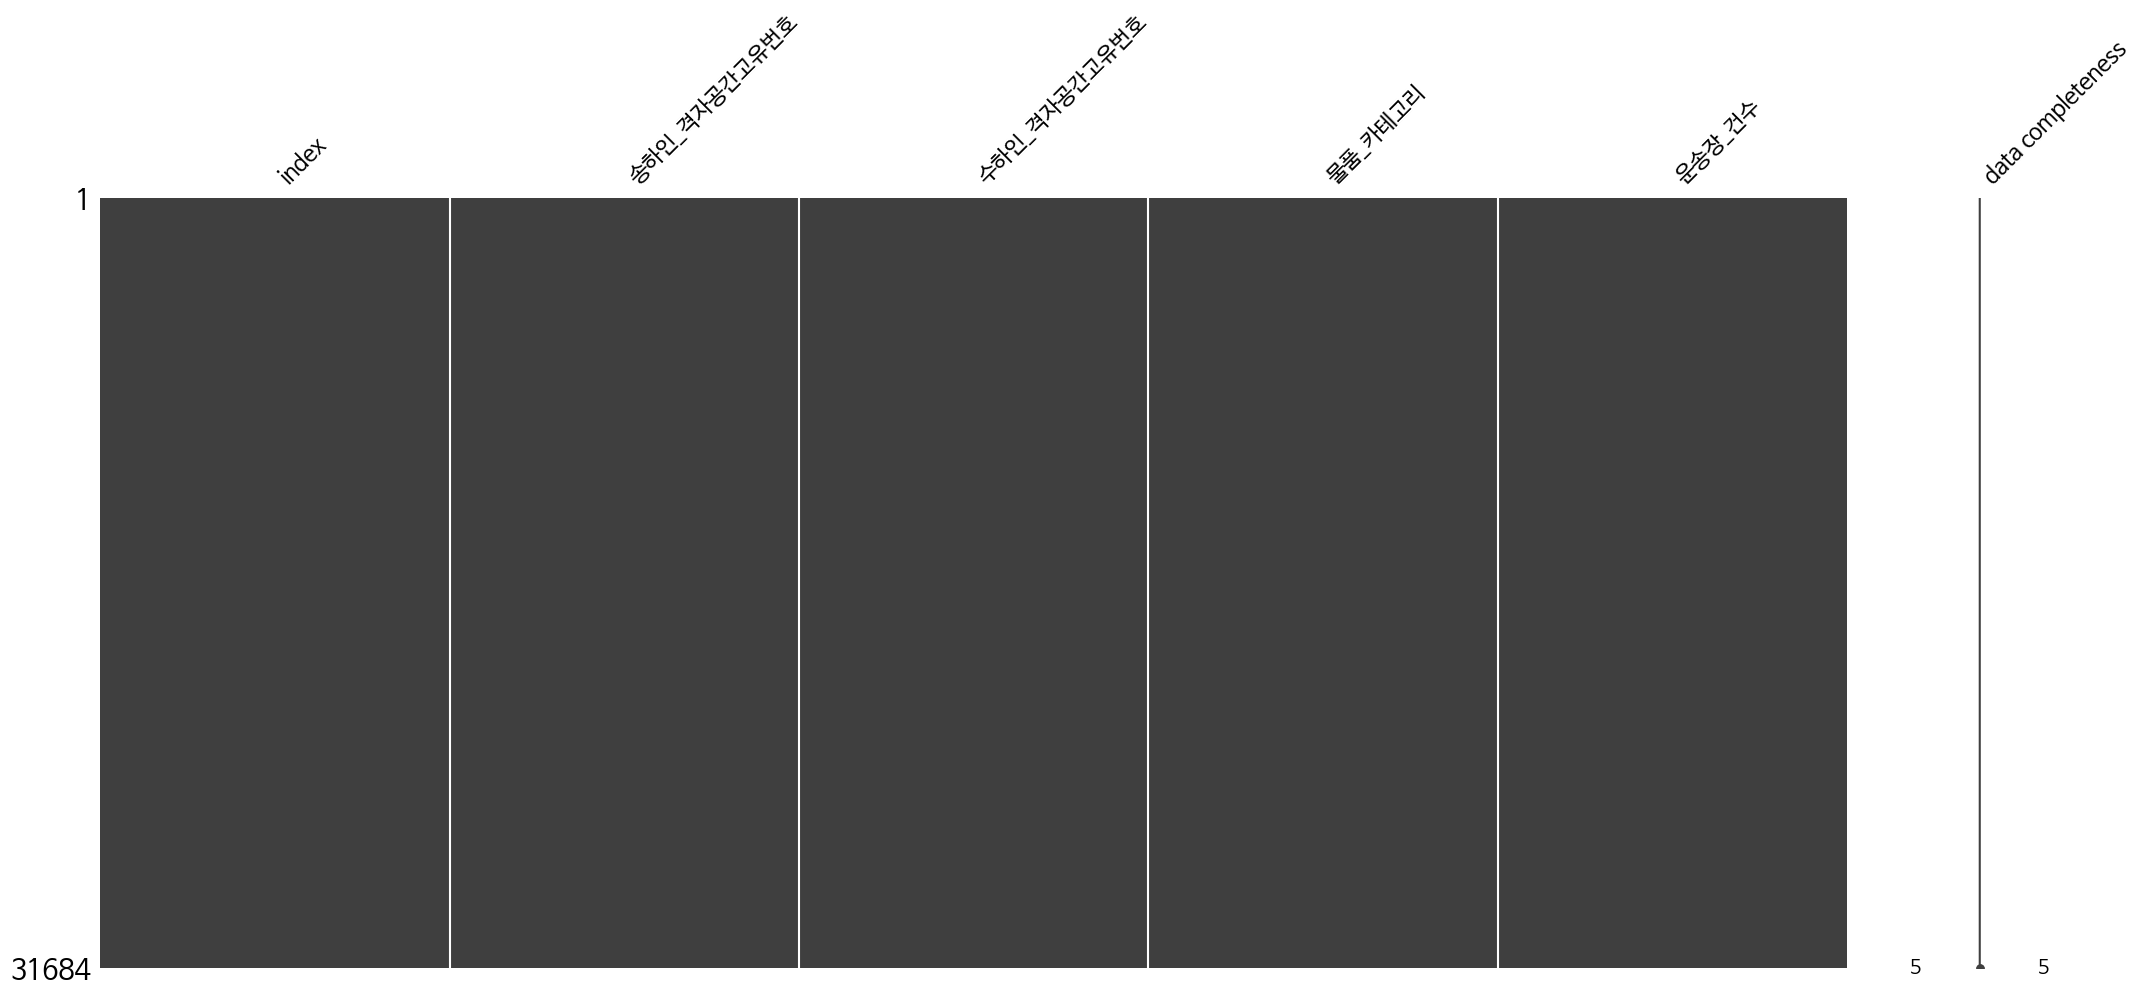

In [57]:
import missingno as msno
msno.matrix(x_train,labels=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


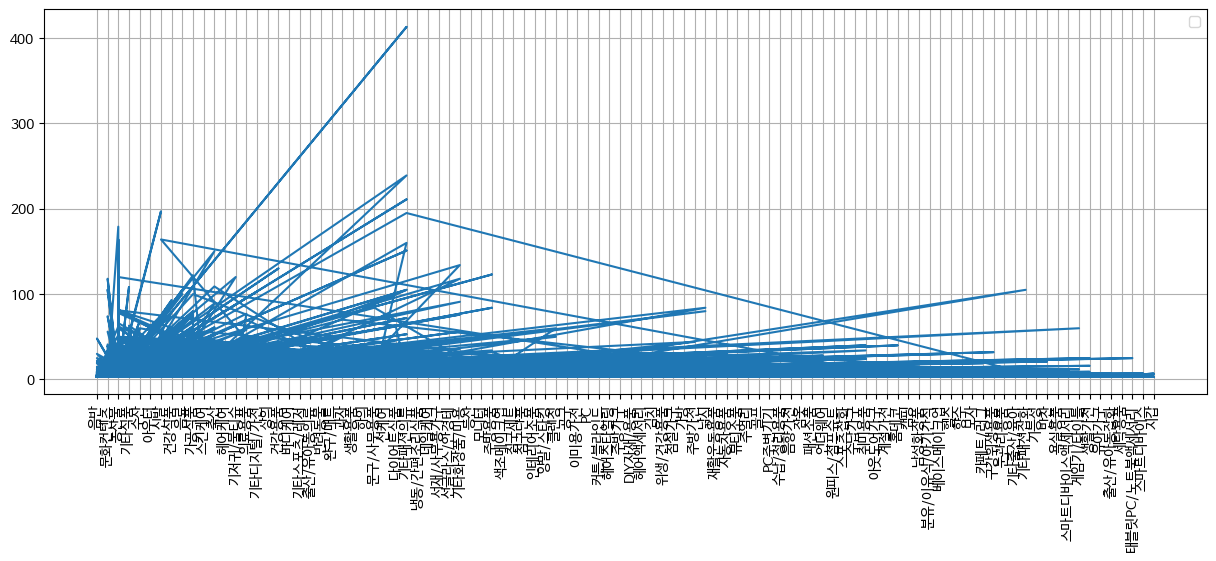

In [58]:
plt.figure(figsize=(15,5))

plt.plot(x_train['물품_카테고리'],x_train['운송장_건수'])
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

<Axes: >

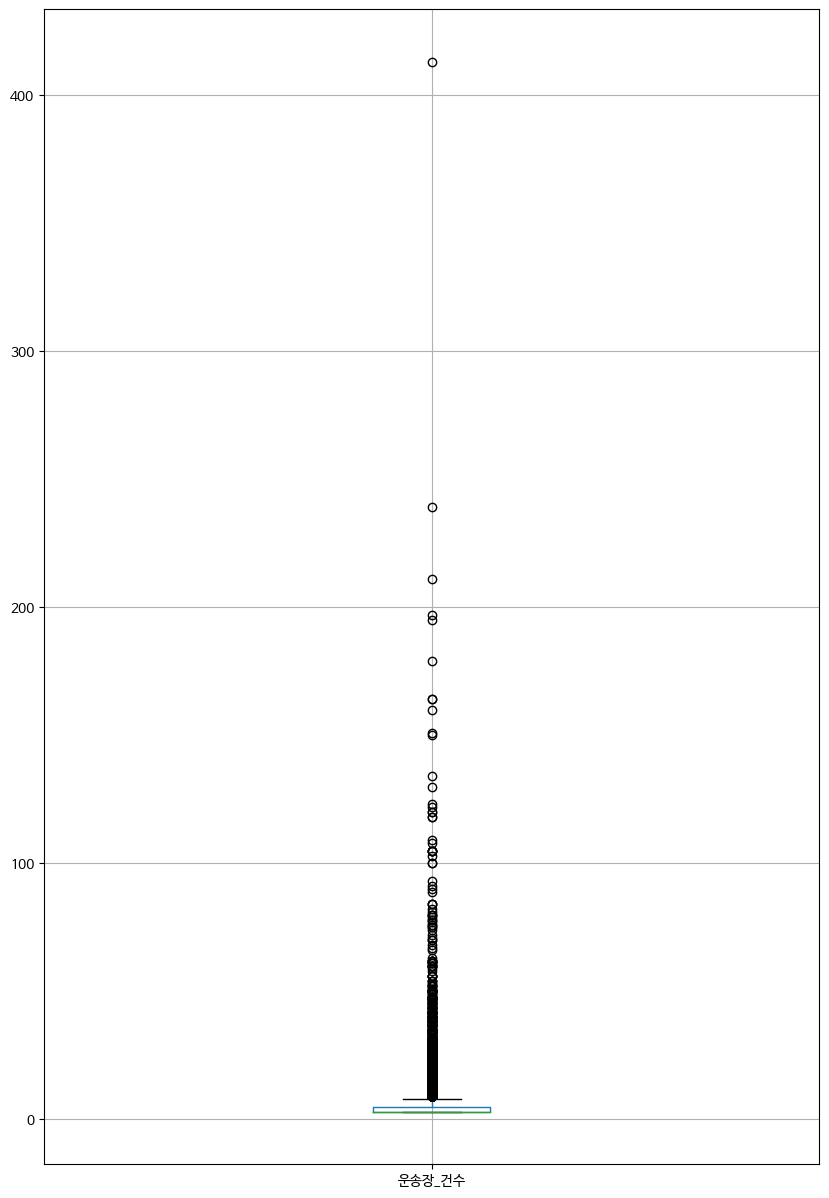

In [59]:
plt.figure(figsize=(10, 15))
x_train.boxplot(column=['운송장_건수'])

In [60]:
encoder = LabelEncoder()
encoder.fit(x_train['물품_카테고리'])

x_train['물품_카테고리'] = encoder.transform(x_train['물품_카테고리'])
x_test['물품_카테고리'] = encoder.transform(x_test['물품_카테고리'])

x_train.head()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수
0,0,5011000595017300,2871000192069300,67,3
1,1,4148000690043300,5011000264024400,34,3
2,2,5011000078068400,1120000007005400,27,3
3,3,4127100048006400,5011000587019400,17,7
4,4,5011000078068400,2823700010076300,27,3



// : 몫

% : 나머지 



In [61]:
def numslice(number,digit) : ## 전체 숫자, 자릿수 -> 
    num = []
    while (number!=0) :
        num.append(number%10)
        number = number//10
    return int(num[-digit])



In [62]:
numslice(1000,1)

1

In [63]:
x_train.shape[0]

31684

In [65]:
for i in range(16) :
    x_train[f'송하인_격자공간고유번호_{i+1}'] = 0
    x_train[f'수하인_격자공간고유번호_{i+1}'] = 0
    x_test[f'송하인_격자공간고유번호_{i+1}'] = 0
    x_test[f'수하인_격자공간고유번호_{i+1}'] = 0
    for j in range(x_train.shape[0]):
        x_train.loc[j,f'송하인_격자공간고유번호_{i+1}'] = numslice(x_train.loc[j,f'송하인_격자공간고유번호'],i+1)
        x_train.loc[j,f'수하인_격자공간고유번호_{i+1}'] = numslice(x_train.loc[j,f'수하인_격자공간고유번호'],i+1)

    for j in range(x_test.shape[0]):
        x_test.loc[j,f'송하인_격자공간고유번호_{i+1}'] = numslice(x_test.loc[j,f'송하인_격자공간고유번호'],i+1)
        x_test.loc[j,f'수하인_격자공간고유번호_{i+1}'] = numslice(x_test.loc[j,f'수하인_격자공간고유번호'],i+1)
    
x_train.head()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_격자공간고유번호_1,수하인_격자공간고유번호_1,송하인_격자공간고유번호_2,수하인_격자공간고유번호_2,송하인_격자공간고유번호_3,...,송하인_격자공간고유번호_12,수하인_격자공간고유번호_12,송하인_격자공간고유번호_13,수하인_격자공간고유번호_13,송하인_격자공간고유번호_14,수하인_격자공간고유번호_14,송하인_격자공간고유번호_15,수하인_격자공간고유번호_15,송하인_격자공간고유번호_16,수하인_격자공간고유번호_16
0,0,5011000595017300,2871000192069300,67,3,5,2,0,8,1,...,1,6,7,9,3,3,0,0,0,0
1,1,4148000690043300,5011000264024400,34,3,4,5,1,0,4,...,4,2,3,4,3,4,0,0,0,0
2,2,5011000078068400,1120000007005400,27,3,5,1,0,1,1,...,6,0,8,5,4,4,0,0,0,0
3,3,4127100048006400,5011000587019400,17,7,4,5,1,0,2,...,0,1,6,9,4,4,0,0,0,0
4,4,5011000078068400,2823700010076300,27,3,5,2,0,8,1,...,6,7,8,6,4,3,0,0,0,0


50110 / 0059 / 50 / 17300 / 

50110


In [66]:
x_train.head()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_격자공간고유번호_1,수하인_격자공간고유번호_1,송하인_격자공간고유번호_2,수하인_격자공간고유번호_2,송하인_격자공간고유번호_3,...,송하인_격자공간고유번호_12,수하인_격자공간고유번호_12,송하인_격자공간고유번호_13,수하인_격자공간고유번호_13,송하인_격자공간고유번호_14,수하인_격자공간고유번호_14,송하인_격자공간고유번호_15,수하인_격자공간고유번호_15,송하인_격자공간고유번호_16,수하인_격자공간고유번호_16
0,0,5011000595017300,2871000192069300,67,3,5,2,0,8,1,...,1,6,7,9,3,3,0,0,0,0
1,1,4148000690043300,5011000264024400,34,3,4,5,1,0,4,...,4,2,3,4,3,4,0,0,0,0
2,2,5011000078068400,1120000007005400,27,3,5,1,0,1,1,...,6,0,8,5,4,4,0,0,0,0
3,3,4127100048006400,5011000587019400,17,7,4,5,1,0,2,...,0,1,6,9,4,4,0,0,0,0
4,4,5011000078068400,2823700010076300,27,3,5,2,0,8,1,...,6,7,8,6,4,3,0,0,0,0


In [67]:
x_train['송하인_격자공간고유번호_1~5'] = x_train['송하인_격자공간고유번호_1'].astype('str')+x_train['송하인_격자공간고유번호_2'].astype('str')+x_train['송하인_격자공간고유번호_3'].astype('str') + x_train['송하인_격자공간고유번호_4'].astype('str') + x_train['송하인_격자공간고유번호_5'].astype('str')
x_train['송하인_격자공간고유번호_6~9'] = x_train['송하인_격자공간고유번호_6'].astype('str') + x_train['송하인_격자공간고유번호_7'].astype('str') + x_train['송하인_격자공간고유번호_8'].astype('str') + x_train['송하인_격자공간고유번호_9'].astype('str')
x_train['송하인_격자공간고유번호_10~11'] = x_train['송하인_격자공간고유번호_10'].astype('str') + x_train['송하인_격자공간고유번호_11'].astype('str')
x_train['송하인_격자공간고유번호_12~16'] = x_train['송하인_격자공간고유번호_12'].astype('str') + x_train['송하인_격자공간고유번호_13'].astype('str') + x_train['송하인_격자공간고유번호_14'].astype('str') + x_train['송하인_격자공간고유번호_15'].astype('str') +  x_train['송하인_격자공간고유번호_16'].astype('str')

x_test['송하인_격자공간고유번호_1~5'] = x_test['송하인_격자공간고유번호_1'].astype('str')+x_test['송하인_격자공간고유번호_2'].astype('str')+x_test['송하인_격자공간고유번호_3'].astype('str') + x_test['송하인_격자공간고유번호_4'].astype('str') + x_test['송하인_격자공간고유번호_5'].astype('str')
x_test['송하인_격자공간고유번호_6~9'] = x_test['송하인_격자공간고유번호_6'].astype('str') + x_test['송하인_격자공간고유번호_7'].astype('str') + x_test['송하인_격자공간고유번호_8'].astype('str') + x_test['송하인_격자공간고유번호_9'].astype('str')
x_test['송하인_격자공간고유번호_10~11'] = x_test['송하인_격자공간고유번호_10'].astype('str') + x_test['송하인_격자공간고유번호_11'].astype('str')
x_test['송하인_격자공간고유번호_12~16'] = x_test['송하인_격자공간고유번호_12'].astype('str') + x_test['송하인_격자공간고유번호_13'].astype('str') + x_test['송하인_격자공간고유번호_14'].astype('str') + x_test['송하인_격자공간고유번호_15'].astype('str') + x_test['송하인_격자공간고유번호_16'].astype('str')

x_train.head()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_격자공간고유번호_1,수하인_격자공간고유번호_1,송하인_격자공간고유번호_2,수하인_격자공간고유번호_2,송하인_격자공간고유번호_3,...,송하인_격자공간고유번호_14,수하인_격자공간고유번호_14,송하인_격자공간고유번호_15,수하인_격자공간고유번호_15,송하인_격자공간고유번호_16,수하인_격자공간고유번호_16,송하인_격자공간고유번호_1~5,송하인_격자공간고유번호_6~9,송하인_격자공간고유번호_10~11,송하인_격자공간고유번호_12~16
0,0,5011000595017300,2871000192069300,67,3,5,2,0,8,1,...,3,3,0,0,0,0,50110,0059,50,17300
1,1,4148000690043300,5011000264024400,34,3,4,5,1,0,4,...,3,4,0,0,0,0,41480,0069,00,43300
2,2,5011000078068400,1120000007005400,27,3,5,1,0,1,1,...,4,4,0,0,0,0,50110,0007,80,68400
3,3,4127100048006400,5011000587019400,17,7,4,5,1,0,2,...,4,4,0,0,0,0,41271,0004,80,06400
4,4,5011000078068400,2823700010076300,27,3,5,2,0,8,1,...,4,3,0,0,0,0,50110,0007,80,68400


In [68]:
x_test.head()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,송하인_격자공간고유번호_1,수하인_격자공간고유번호_1,송하인_격자공간고유번호_2,수하인_격자공간고유번호_2,송하인_격자공간고유번호_3,수하인_격자공간고유번호_3,...,송하인_격자공간고유번호_14,수하인_격자공간고유번호_14,송하인_격자공간고유번호_15,수하인_격자공간고유번호_15,송하인_격자공간고유번호_16,수하인_격자공간고유번호_16,송하인_격자공간고유번호_1~5,송하인_격자공간고유번호_6~9,송하인_격자공간고유번호_10~11,송하인_격자공간고유번호_12~16
0,0,4167000577042200,5011000435014100,47,4,5,1,0,6,1,...,2,1,0,0,0,0,41670,0057,70,42200
1,1,1156000009012200,5011000172034400,12,1,5,1,0,5,1,...,2,4,0,0,0,0,11560,0000,90,12200
2,2,4122000363057300,5011000361097300,88,4,5,1,0,2,1,...,3,3,0,0,0,0,41220,0036,30,57300
3,3,5011000436041400,2826000084036400,58,5,2,0,8,1,2,...,4,4,0,0,0,0,50110,0043,60,41400
4,4,4150000241065200,5011000169044300,39,4,5,1,0,5,1,...,2,3,0,0,0,0,41500,0024,10,65200


In [69]:
x_train['수하인_격자공간고유번호_1~5'] = x_train['수하인_격자공간고유번호_1'].astype('str')+x_train['수하인_격자공간고유번호_2'].astype('str')+x_train['수하인_격자공간고유번호_3'].astype('str') + x_train['수하인_격자공간고유번호_4'].astype('str') + x_train['수하인_격자공간고유번호_5'].astype('str')
x_train['수하인_격자공간고유번호_6~9'] = x_train['수하인_격자공간고유번호_6'].astype('str') + x_train['수하인_격자공간고유번호_7'].astype('str') + x_train['수하인_격자공간고유번호_8'].astype('str') + x_train['수하인_격자공간고유번호_9'].astype('str')
x_train['수하인_격자공간고유번호_10~11'] = x_train['수하인_격자공간고유번호_10'].astype('str') + x_train['수하인_격자공간고유번호_11'].astype('str')
x_train['수하인_격자공간고유번호_12~16'] = x_train['수하인_격자공간고유번호_12'].astype('str') + x_train['수하인_격자공간고유번호_13'].astype('str') + x_train['수하인_격자공간고유번호_14'].astype('str') + x_train['수하인_격자공간고유번호_15'].astype('str') +  x_train['수하인_격자공간고유번호_16'].astype('str')

x_test['수하인_격자공간고유번호_1~5'] = x_test['수하인_격자공간고유번호_1'].astype('str')+x_test['수하인_격자공간고유번호_2'].astype('str')+x_test['수하인_격자공간고유번호_3'].astype('str') + x_test['수하인_격자공간고유번호_4'].astype('str') + x_test['수하인_격자공간고유번호_5'].astype('str')
x_test['수하인_격자공간고유번호_6~9'] = x_test['수하인_격자공간고유번호_6'].astype('str') + x_test['수하인_격자공간고유번호_7'].astype('str') + x_test['수하인_격자공간고유번호_8'].astype('str') + x_test['수하인_격자공간고유번호_9'].astype('str')
x_test['수하인_격자공간고유번호_10~11'] = x_test['수하인_격자공간고유번호_10'].astype('str') + x_test['수하인_격자공간고유번호_11'].astype('str')
x_test['수하인_격자공간고유번호_12~16'] = x_test['수하인_격자공간고유번호_12'].astype('str') + x_test['수하인_격자공간고유번호_13'].astype('str') + x_test['수하인_격자공간고유번호_14'].astype('str') + x_test['수하인_격자공간고유번호_15'].astype('str') + x_test['수하인_격자공간고유번호_16'].astype('str')


In [70]:
x_train.head()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_격자공간고유번호_1,수하인_격자공간고유번호_1,송하인_격자공간고유번호_2,수하인_격자공간고유번호_2,송하인_격자공간고유번호_3,...,송하인_격자공간고유번호_16,수하인_격자공간고유번호_16,송하인_격자공간고유번호_1~5,송하인_격자공간고유번호_6~9,송하인_격자공간고유번호_10~11,송하인_격자공간고유번호_12~16,수하인_격자공간고유번호_1~5,수하인_격자공간고유번호_6~9,수하인_격자공간고유번호_10~11,수하인_격자공간고유번호_12~16
0,0,5011000595017300,2871000192069300,67,3,5,2,0,8,1,...,0,0,50110,0059,50,17300,28710,0019,20,69300
1,1,4148000690043300,5011000264024400,34,3,4,5,1,0,4,...,0,0,41480,0069,00,43300,50110,0026,40,24400
2,2,5011000078068400,1120000007005400,27,3,5,1,0,1,1,...,0,0,50110,0007,80,68400,11200,0000,70,05400
3,3,4127100048006400,5011000587019400,17,7,4,5,1,0,2,...,0,0,41271,0004,80,06400,50110,0058,70,19400
4,4,5011000078068400,2823700010076300,27,3,5,2,0,8,1,...,0,0,50110,0007,80,68400,28237,0001,00,76300


In [71]:
for i in range(1,17):
    x_train.drop('송하인_격자공간고유번호_'+str(i),axis=1,inplace=True)
    x_test.drop('송하인_격자공간고유번호_'+str(i),axis=1,inplace=True)
    x_train.drop('수하인_격자공간고유번호_'+str(i),axis=1,inplace=True)
    x_test.drop('수하인_격자공간고유번호_'+str(i),axis=1,inplace=True)
    

In [72]:
x_train.head()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_격자공간고유번호_1~5,송하인_격자공간고유번호_6~9,송하인_격자공간고유번호_10~11,송하인_격자공간고유번호_12~16,수하인_격자공간고유번호_1~5,수하인_격자공간고유번호_6~9,수하인_격자공간고유번호_10~11,수하인_격자공간고유번호_12~16
0,0,5011000595017300,2871000192069300,67,3,50110,0059,50,17300,28710,0019,20,69300
1,1,4148000690043300,5011000264024400,34,3,41480,0069,00,43300,50110,0026,40,24400
2,2,5011000078068400,1120000007005400,27,3,50110,0007,80,68400,11200,0000,70,05400
3,3,4127100048006400,5011000587019400,17,7,41271,0004,80,06400,50110,0058,70,19400
4,4,5011000078068400,2823700010076300,27,3,50110,0007,80,68400,28237,0001,00,76300


In [73]:
x_test.head()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,송하인_격자공간고유번호_1~5,송하인_격자공간고유번호_6~9,송하인_격자공간고유번호_10~11,송하인_격자공간고유번호_12~16,수하인_격자공간고유번호_1~5,수하인_격자공간고유번호_6~9,수하인_격자공간고유번호_10~11,수하인_격자공간고유번호_12~16
0,0,4167000577042200,5011000435014100,47,41670,0057,70,42200,50110,0043,50,14100
1,1,1156000009012200,5011000172034400,12,11560,0000,90,12200,50110,0017,20,34400
2,2,4122000363057300,5011000361097300,88,41220,0036,30,57300,50110,0036,10,97300
3,3,5011000436041400,2826000084036400,58,50110,0043,60,41400,28260,0008,40,36400
4,4,4150000241065200,5011000169044300,39,41500,0024,10,65200,50110,0016,90,44300


In [74]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31684 entries, 0 to 31683
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index               31684 non-null  int64 
 1   송하인_격자공간고유번호        31684 non-null  int64 
 2   수하인_격자공간고유번호        31684 non-null  int64 
 3   물품_카테고리             31684 non-null  int32 
 4   운송장_건수              31684 non-null  int64 
 5   송하인_격자공간고유번호_1~5    31684 non-null  object
 6   송하인_격자공간고유번호_6~9    31684 non-null  object
 7   송하인_격자공간고유번호_10~11  31684 non-null  object
 8   송하인_격자공간고유번호_12~16  31684 non-null  object
 9   수하인_격자공간고유번호_1~5    31684 non-null  object
 10  수하인_격자공간고유번호_6~9    31684 non-null  object
 11  수하인_격자공간고유번호_10~11  31684 non-null  object
 12  수하인_격자공간고유번호_12~16  31684 non-null  object
dtypes: int32(1), int64(4), object(8)
memory usage: 3.0+ MB


In [75]:
y_train = x_train[['운송장_건수']]
x_train = x_train.loc[:,['물품_카테고리','송하인_격자공간고유번호_1~5','송하인_격자공간고유번호_6~9','송하인_격자공간고유번호_10~11','송하인_격자공간고유번호_12~16','수하인_격자공간고유번호_1~5','수하인_격자공간고유번호_6~9','수하인_격자공간고유번호_10~11','수하인_격자공간고유번호_12~16']]

x_test = x_test.loc[:,['물품_카테고리','송하인_격자공간고유번호_1~5','송하인_격자공간고유번호_6~9','송하인_격자공간고유번호_10~11','송하인_격자공간고유번호_12~16','수하인_격자공간고유번호_1~5','수하인_격자공간고유번호_6~9','수하인_격자공간고유번호_10~11','수하인_격자공간고유번호_12~16']]


In [77]:
x_test.head()

,물품_카테고리,송하인_격자공간고유번호_1~5,송하인_격자공간고유번호_6~9,송하인_격자공간고유번호_10~11,송하인_격자공간고유번호_12~16,수하인_격자공간고유번호_1~5,수하인_격자공간고유번호_6~9,수하인_격자공간고유번호_10~11,수하인_격자공간고유번호_12~16
0,47,41670,0057,70,42200,50110,0043,50,14100
1,12,11560,0000,90,12200,50110,0017,20,34400
2,88,41220,0036,30,57300,50110,0036,10,97300
3,58,50110,0043,60,41400,28260,0008,40,36400
4,39,41500,0024,10,65200,50110,0016,90,44300


In [81]:
from sklearn.model_selection import train_test_split

In [82]:
x_tr,x_val,y_tr,y_val = train_test_split(x_train,y_train,test_size=0.3,shuffle=3,random_state=31)

C:\Users\hamin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


In [83]:
from sklearn.model_selection import RandomizedSearchCV

In [84]:
rf_model=RandomForestRegressor(random_state=123)
param_grid = {'n_estimators':[100,150],
                'max_depth':[3,4]}

rf_search = RandomizedSearchCV(rf_model,param_grid,cv=5,
        return_train_score = True)

rf_search.fit(x_tr,y_tr)



C:\Users\hamin\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\hamin\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hamin\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hamin\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please c

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123),
                   param_distributions={'max_depth': [3, 4],
                                        'n_estimators': [100, 150]},
                   return_train_score=True)

In [85]:
rf_val_pred = rf_search.best_estimator_.predict(x_val)
rf_val_pred

array([4.50116093, 6.14801813, 4.49691237, ..., 4.58489824, 3.90241519,
       4.4876124 ])

In [89]:
rf_tr_pred = rf_search.best_estimator_.predict(x_tr)
rf_tr_pred

array([4.46248383, 4.77394855, 4.26209352, ..., 5.5042144 , 4.86128734,
       6.41174537])

In [87]:
from sklearn.metrics import  mean_squared_error

In [93]:
tr_mse = mean_squared_error(y_tr,rf_tr_pred)
print("Tr MSE:%3f" % np.sqrt(tr_mse))

Tr MSE:6.265965


In [92]:
val_mse = mean_squared_error(y_val,rf_val_pred)
print("Val MSE:%3f" % np.sqrt(val_mse))

Val MSE:5.624694
